In [1]:
import pandas as pd
import re
import string

import nltk
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df =  pd.read_csv('wine.csv')

In [3]:
df.shape

(11258, 10)

In [4]:
df = df.dropna(subset=['description'])

In [5]:
df.shape

(11258, 10)

## Text Cleaning

In [6]:
# Get a list of varietals so we can use them as stop words
varietals = ' '.join(df.variety.unique().tolist()).lower()
varietals = re.sub('-', ' ', varietals)
varietals = varietals.split()

In [7]:
# Load spacy
nlp = spacy.load('en_core_web_sm')

def clean_string(text):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub('\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Lemmatize
    text = nlp(text)
    text = [y.lemma_ for y in text]
    
    # Convert to list
    # text = text.split()
    
    # Remove stop words
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + varietals + ['drink', 'wine']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]


    final_string = ' '.join(text_filtered)

    return final_string

In [8]:
# Next apply the clean_string function to the text
df['description_clean'] = df['description'].apply(lambda x: clean_string(x))

In [9]:
df['description'][0]

"Malbec, Merlot and Petit Verdot are included in this wine that's black-purple in color, with a thick density to its dusty black fruit. Cedar, tar and tobacco weave in between blackberry and currant, finishing in a powerful grip of tannin."

In [10]:
df['description_clean'][0]

'include blackpurple color thick density dusty fruit cedar tar tobacco weave blackberry currant finishing powerful grip tannin'

## Determine the Optimal Number of Clusters

To select the best number of clusters, we'll use the Elbow method.  Per [Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

> *In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The same method can be used to choose the number of parameters in other data-driven models, such as the number of principal components to describe a data set.*

[Tutorial: How to determine the optimal number of clusters for k-means clustering](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['description_clean'])

In [51]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(init="k-means++", n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

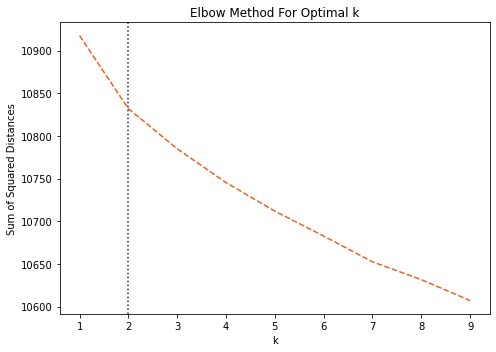

In [74]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(x=K, y=Sum_of_squared_distances)
#732F2F
ax.lines[0].set_linestyle("--")
ax.lines[0].set_color("#F25D27")

# Add a vertical line to show the optimum number of clusters
plt.axvline(2, color='#1A2226', linestyle=':')

plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')

plt.tight_layout()
plt.savefig('textclustering_elbow.png', dpi=300)
plt.show();

## Silhouette Score

The Silhouette Coefficient is calculated using the mean intra-cluster distance (`a`) and the mean nearest-cluster distance (`b`) for each sample. The Silhouette Coefficient for a sample is `(b - a) / max(a, b)`. To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is `2 <= n_labels <= n_samples - 1`.

The best value is `1`, and the worst value is `-1`. Values near `0` indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html?highlight=silhouette_score#sklearn.metrics.silhouette_score

In [57]:
def get_silhouette_score(X, k):
    for n_clusters in range(2, k):
        clusterer = KMeans(init="k-means++", n_clusters=n_clusters, random_state=42)
        y = clusterer.fit_predict(X)

        message = "For n_clusters = {} The average silhouette_score is: {}"
        print(message.format(n_clusters, silhouette_score(X, y)))
        
get_silhouette_score(X, 10)

For n_clusters = 2 The average silhouette_score is: 0.00821919113279018
For n_clusters = 3 The average silhouette_score is: 0.006522933295313797
For n_clusters = 4 The average silhouette_score is: 0.006237960319271207
For n_clusters = 5 The average silhouette_score is: 0.006266850309331783
For n_clusters = 6 The average silhouette_score is: 0.006381665959703946
For n_clusters = 7 The average silhouette_score is: 0.005549433908077499
For n_clusters = 8 The average silhouette_score is: 0.005962146586290015
For n_clusters = 9 The average silhouette_score is: 0.00632540099660495


## Clustering with k-Means

In [58]:
# Set the number of clusters
k = 2
# Vectorize the text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['description_clean'])
# Fit our Model
model = KMeans(init="k-means++", n_clusters=k, max_iter=25, n_init=1)
model.fit(X)

KMeans(max_iter=25, n_clusters=2, n_init=1)

In [59]:
# Get the cluster labels
clust_labels = model.predict(X)
cent = model.cluster_centers_

kmeans_labels = pd.DataFrame(clust_labels)
df.insert((df.shape[1]),'clusters',kmeans_labels)

In [60]:
df.sample(5, random_state=3)

,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_clean,clusters
2131,US,If you like your white wines with a white suga...,Estate,82,16.0,California,Dry Creek Valley,Sonoma,Sauvignon Blanc,Mill Creek,like sugary finish taste like apricot pineappl...,0
641,US,"Feels harsh and tart in the mouth, with sharp ...",Crazy Creek Vineyard Estate Bottled,82,40.0,California,Alexander Valley,Sonoma,Cabernet Sauvignon,DeLorimier,feel harsh tart mouth sharp acidity give oakyc...,1
1964,US,Hot in alcohol and seemingly sweet in black cu...,Estate Grown,83,30.0,California,Dry Creek Valley,Sonoma,Malbec,Mounts,hot alcohol seemingly sweet currant chocolate ...,1
4684,US,"Made without oak, although the wine has a tart...",Unoaked,86,18.0,California,Russian River Valley,Sonoma,Chardonnay,Sebastiani,make without oak although tart leanness would ...,0
2512,US,This is an enormously fruity Zinfandel that of...,Bradford Mountain Vineyard,91,32.0,California,Dry Creek Valley,Sonoma,Zinfandel,Peterson,enormously fruity offer flood flavor make inst...,1


In [61]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

results_dict = {}

for i in range(k):
    terms_list = []
    
    for ind in order_centroids[i, :15]:  
        terms_list.append(terms[ind])
    
    results_dict[f'Cluster {i}'] = terms_list
    
df_clusters = pd.DataFrame.from_dict(results_dict)
df_clusters

,Cluster 0,Cluster 1
0,pineapple,cherry
1,flavor,flavor
2,acidity,dry
3,vanilla,blackberry
4,fruit,tannin
5,oak,cola
6,crisp,raspberry
7,pear,currant
8,apple,good
9,peach,rich


In [62]:
new_docs = ['Rich deep color of oak and chocolate.',
            'Light and crisp with a hint of vanilla.',
            'Hints of citrus and melon.',
            'Dark raspberry and black cherry flavors.']

pred = model.predict(vectorizer.transform(new_docs))
print(pred)

[1 0 0 1]
